In [ ]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

conda install --channel defaults conda python=3.8 --yes
conda update --channel defaults --all --yes

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive"
base_dir=os.path.join(path, 'Colab Notebooks/super-convergence')
os.chdir(base_dir)
os.listdir(base_dir)

Mounted at /content/drive


['Results',
 'architectures',
 'data',
 'models.ipynb',
 'dataset.ipynb',
 'learning_rates.ipynb',
 'tools.ipynb',
 'train.ipynb']

In [3]:
%run dataset.ipynb
%run tools.ipynb
%run models.ipynb
%run learning_rates.ipynb

import numpy as np
import torch
import torch.nn as nn

from IPython import display
from PIL import Image
import matplotlib.pyplot as plt
import math
import time
import random

In [4]:
train_augs = torchvision.transforms.Compose(
[torchvision.transforms.RandomHorizontalFlip(),
#  torchvision.transforms.RandomVerticalFlip(),
 torchvision.transforms.ToTensor()]
)

test_augs = torchvision.transforms.Compose([
# torchvision.transforms.RandomHorizontalFlip(),
#  torchvision.transforms.RandomVerticalFlip(),
 torchvision.transforms.ToTensor()
]
)

def train_batch(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices, animator, mode):
    """use GPU training model)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)

    print('training on', devices)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0]) # multi GPU
    # net.to(devices)

    # animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
    #                         legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # if epoch == 3 and mode == "CLR":
        #   break;

        # 4 dims: training loss, training accuarcy, num of samples, points
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            if mode == "CLR":
              lr = CyclicLR(len(train_iter)*epoch+i, 1, 30, 550)
              trainer.param_groups[0]["lr"]=lr
            timer.start()
            l, acc = train_batch(net, features, labels, loss, trainer,
                                      devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            # if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                # animator.add(
                #     epoch + (i + 1) / num_batches,
                #     (metric[1] / metric[3], None))
                # animator.add(
                #     epoch + (i + 1) / num_batches,
                #     (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        if mode == "RL":
        # animator.add(epoch + 1, (None, None, test_acc))
          animator.add(epoch + 1, (test_acc, None))
        if mode == "CLR":
          animator.add(epoch + 1, (None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [ ]:
net = resnet18(10, 3)
num_epochs, batch_size, devices = 10, 256, try_all_gpus()
# lr, num_epochs, batch_size, devices = 0.05, 10, 256, try_gpu()
lr1=0.0035
lr2=0.001

# train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96) # load_data_fashion_mnist in dataset.ipynb
train_iter = load_cifar100(True, train_augs, batch_size)
test_iter = load_cifar100(False, test_augs, batch_size)

loss = nn.CrossEntropyLoss()

trainer1 = torch.optim.Adam(net.parameters(), lr=lr1)
trainer2 = torch.optim.Adam(net.parameters(), lr=lr2)
# trainer2 = torch.optim.SGD(net2.parameters(), lr=lr2)

animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['RL test acc', 'CLR test acc'])
same_seeds(2)
train(net, train_iter, test_iter, loss, trainer2, num_epochs, devices, animator, "CLR")
same_seeds(2)
train(net, train_iter, test_iter, loss, trainer1, num_epochs, devices, animator,"RL")

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

# net = resnet18(10, 1)
num_epochs, batch_size, devices = 10, 256, try_all_gpus()
# lr, num_epochs, batch_size, devices = 0.05, 10, 256, try_gpu()
lr1=0.0035
lr2=0.001

train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96) # load_data_fashion_mnist in dataset.ipynb
# train_iter = load_cifar100(True, train_augs, batch_size)
# test_iter = load_cifar100(False, test_augs, batch_size)

loss = nn.CrossEntropyLoss()

trainer1 = torch.optim.Adam(net.parameters(), lr=lr1)
trainer2 = torch.optim.Adam(net.parameters(), lr=lr2)
# trainer2 = torch.optim.SGD(net2.parameters(), lr=lr2)

animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['RL test acc', 'CLR test acc'])
# same_seeds(2)
train(net, train_iter, test_iter, loss, trainer2, num_epochs, devices, animator, "CLR")
# same_seeds(2)
train(net, train_iter, test_iter, loss, trainer1, num_epochs, devices, animator,"RL")

loss 0.002, train acc 0.852, test acc 0.852
2201.0 examples/sec on [device(type='cuda', index=0)]


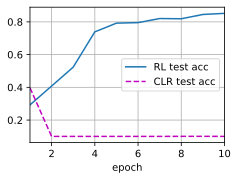

In [ ]:
net = resnet56(10)
num_epochs, batch_size, devices = 10, 256, try_all_gpus()
lr1=0.35
lr2=0.1

# train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96) # load_data_fashion_mnist in dataset.ipynb
train_iter = load_data_fashion_mnist(True, train_augs, batch_size)
test_iter = load_data_fashion_mnist(False, test_augs, batch_size)

loss = nn.CrossEntropyLoss()

trainer1 = torch.optim.Adam(net.parameters(), lr=lr1)
trainer2 = torch.optim.Adam(net.parameters(), lr=lr2)
# trainer2 = torch.optim.SGD(net2.parameters(), lr=lr2)

animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['RL test acc', 'CLR test acc'])
# same_seeds(1)
train(net, train_iter, test_iter, loss, trainer2, num_epochs, devices, animator, "CLR")
# same_seeds(1)
train(net, train_iter, test_iter, loss, trainer1, num_epochs, devices, animator,"RL")

loss 0.007, train acc 0.736, test acc 0.732
9103.6 examples/sec on [device(type='cpu')]


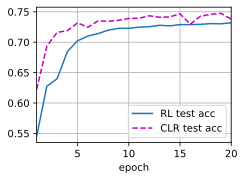

In [ ]:
net = MLP()
num_epochs, batch_size, devices = 20, 256, try_all_gpus()
lr1=0.035
lr2=0.01

# train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96) # load_data_fashion_mnist in dataset.ipynb
train_iter = load_data_fashion_mnist(True, train_augs, batch_size)
test_iter = load_data_fashion_mnist(False, test_augs, batch_size)

x_train = x_train.reshape(-1, 3072)
x_test = x_test.reshape(-1, 3072)

loss = nn.CrossEntropyLoss()

# trainer1 = torch.optim.Adam(net.parameters(), lr=lr1)
# trainer2 = torch.optim.Adam(net.parameters(), lr=lr2)
trainer2 = torch.optim.SGD(net.parameters(), lr=lr2)
trainer1 = torch.optim.SGD(net.parameters(), lr=lr1)

animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['RL test acc', 'CLR test acc'])
# same_seeds(1)
train(net, train_iter, test_iter, loss, trainer2, num_epochs, devices, animator, "CLR")
# same_seeds(1)
train(net, train_iter, test_iter, loss, trainer1, num_epochs, devices, animator,"RL")

In [ ]:
net = MLPNet(100,1,"sigmoid")
num_epochs, batch_size, devices = 20, 256, try_all_gpus()
lr1=3.5
lr2=1

# train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96) # load_data_fashion_mnist in dataset.ipynb
train_iter = load_cifar100(True, train_augs, batch_size)
test_iter = load_cifar100(False, test_augs, batch_size)


# x_train = x_train.reshape(-1, 3072)
# x_test = x_test.reshape(-1, 3072)

loss = nn.CrossEntropyLoss()

# trainer1 = torch.optim.Adam(net.parameters(), lr=lr1)
# trainer2 = torch.optim.Adam(net.parameters(), lr=lr2)
trainer2 = torch.optim.SGD(net.parameters(), lr=lr2)
trainer1 = torch.optim.SGD(net.parameters(), lr=lr1)

animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['RL test acc', 'CLR test acc'])
# same_seeds(1)
train(net, train_iter, test_iter, loss, trainer2, num_epochs, devices, animator, "CLR")
# same_seeds(1)
train(net, train_iter, test_iter, loss, trainer1, num_epochs, devices, animator,"RL")